Prepare Data:

1.   Prepare Data:

2.   Create a Data Generator

3.   Build the DenseNet Model

4.   Compile the Model

5.   Train the Model

6.   Evaluate the Model

#Import Libraries


In [1]:
!pip install kaggle
!pip install SimpleITK
!pip install imgaug

import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from sklearn.model_selection import train_test_split

import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub

import numpy as np # linear algebra
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 15.6 MB/s eta 0:00:00




#Import Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

folder_path_no =  "/content/drive/MyDrive/DDLS/no"
folder_path_yes = "/content/drive/MyDrive/DDLS/yes"

folder_no = os.listdir(folder_path_no)
folder_yes = os.listdir(folder_path_yes)

print("Number of Images With Tumors\t", len(folder_yes))
print("Number of Images Without Tumors\t", len(folder_no))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of Images Without Tumors	 98
Number of Images With Tumors	 155


#Preprocessing
Loads, resizes, normalizes the MRI images from the "no" and "yes" folders.

In [ ]:
import os
import cv2


# Create lists to store preprocessed images
yes_tumor = []
no_tumor = []

# Function to preprocess and denoise an image
def preprocess_image(file_path, target_size=(256, 256), denoise=True):
    try:
        # Load the MRI image using OpenCV
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        # Resize the image to the target size
        image = cv2.resize(image, target_size)

        # Denoise the image using Non-Local Means (NLM)
        if denoise:
            image = cv2.fastNlMeansDenoising(image, None, h=10, templateWindowSize=7, searchWindowSize=21)

        # Normalize pixel values to [0, 1]
        image = image / 255.0

        return image

    except Exception as e:
        return None

# Preprocess and denoise images in the "yes" folder
for filename in os.listdir(folder_path_yes):
    file_path = os.path.join(folder_path_yes, filename)
    preprocessed_image = preprocess_image(file_path, denoise=True)
    if preprocessed_image is not None:
        yes_tumor.append(preprocessed_image)

# Preprocess and denoise images in the "no" folder
for filename in os.listdir(folder_path_no):
    file_path = os.path.join(folder_path_no, filename)
    preprocessed_image = preprocess_image(file_path, denoise=True)
    if preprocessed_image is not None:
        no_tumor.append(preprocessed_image)

# Print the number of preprocessed images in each category
print("Number of 'yes_tumor' images\t", len(yes_tumor))
print("Number of 'no_tumor' images\t", len(no_tumor))


Number of 'yes_tumor' images	 155
Number of 'no_tumor' images	 98


Visualize the Original Data

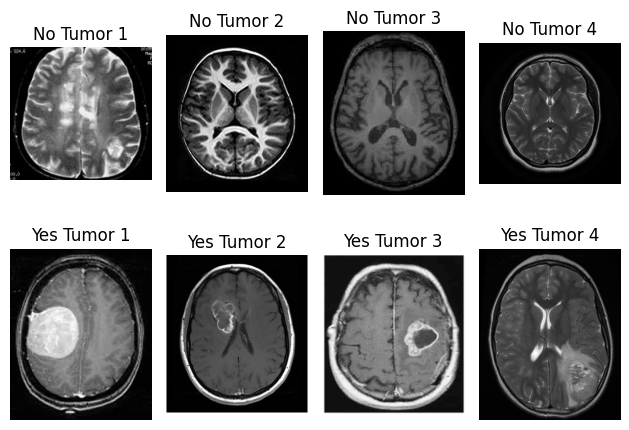

In [ ]:
import SimpleITK as sitk

# Load and visualize the first 4 images from the "no" folder
for i, filename in enumerate(os.listdir(folder_path_no)[:4]):
    file_path = os.path.join(folder_path_no, filename)
    image = sitk.ReadImage(file_path)

    plt.subplot(2, 4, i + 1)
    plt.imshow(sitk.GetArrayFromImage(image), cmap='gray')
    plt.title(f'No Tumor {i + 1}')
    plt.axis('off')

# Load and visualize the first 4 images from the "yes" folder
for i, filename in enumerate(os.listdir(folder_path_yes)[:4]):
    file_path = os.path.join(folder_path_yes, filename)
    image = sitk.ReadImage(file_path)

    plt.subplot(2, 4, 4 + i + 1)
    plt.imshow(sitk.GetArrayFromImage(image), cmap='gray')
    plt.title(f'Yes Tumor {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()




Visualize the preprocessed images


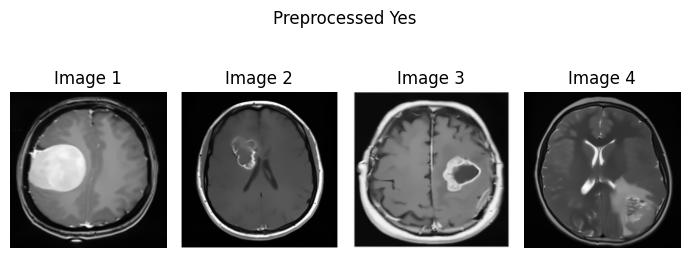

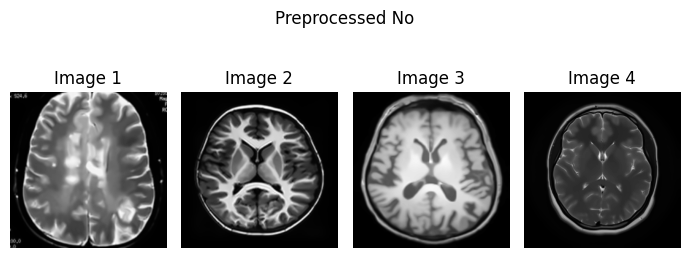

In [ ]:

def plot_images(image_list, title, num_images=4, figsize=(10, 6)):
    num_images = min(num_images, len(image_list))
    cols = 4  # Number of columns in the grid
    rows = (num_images + cols - 1) // cols  # Calculate the number of rows

    # Set the figure size
    plt.figure(figsize=figsize)
    plt.suptitle(title)

    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_list[i], cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the first 4 preprocessed 'yes_tumor' images in a smaller size
plot_images(yes_tumor, title="Preprocessed Yes", figsize=(7, 3))

# Visualize the first 4 preprocessed 'no_tumor' images in a smaller size
plot_images(no_tumor, title="Preprocessed No", figsize=(7, 3))


Length & Shape

In [ ]:
print("Number of 'yes_tumor' images:", len(yes_tumor), "\tShape:", yes_tumor[0].shape)
print("Number of 'no_tumor' images:", len(no_tumor),"\tShape:",no_tumor[0].shape)


Number of 'yes_tumor' images: 155 	Shape: (256, 256)
Number of 'no_tumor' images: 98 	Shape: (256, 256)


#Data Augmentation

In [ ]:
import numpy as np
import imgaug.augmenters as iaa

augmentation = iaa.Sequential([
    iaa.Affine(rotate=(-10, 10)),  # Mild rotation to maintain tumor orientation
    iaa.Fliplr(0.5),  # Horizontal flips can simulate different viewpoints
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 1.0))),  # Mild blurring for realism
    iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=(0, 0.01*255))),  # Noise for robustness
    iaa.ContrastNormalization((0.8, 1.2)),  # Contrast variations for robustness
], random_order=True)


# Define a function to augment and store the augmented data
def augment_data(images, num_augmentations=8):
    augmented_images = []

    for image in images:
        image = (image * 255).astype(np.uint8)  # Convert to uint8
        augmented = [augmentation.augment_image(image) for _ in range(num_augmentations)]
        augmented_images.extend(augmented)

    return augmented_images

# Augment the 'yes_tumor' and 'no_tumor' images
augmented_yes_tumor = augment_data(yes_tumor)
augmented_no_tumor = augment_data(no_tumor)


Length & Shape


In [ ]:
print("Number of 'augmented_yes_tumor' images:", len(augmented_yes_tumor), "\tShape:", augmented_yes_tumor[0].shape)
print("Number of 'augmented_no_tumor'  images:", len(augmented_no_tumor), "\tShape:", augmented_no_tumor[0].shape)


Number of 'augmented_yes_tumor' images: 1240 	Shape: (256, 256, 1)
Number of 'augmented_no_tumor'  images: 784 	Shape: (256, 256, 1)


Visualize the Augmented data


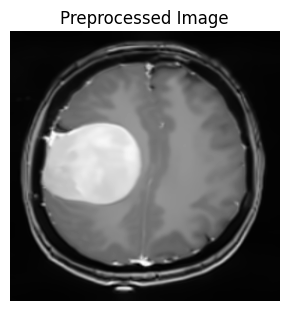

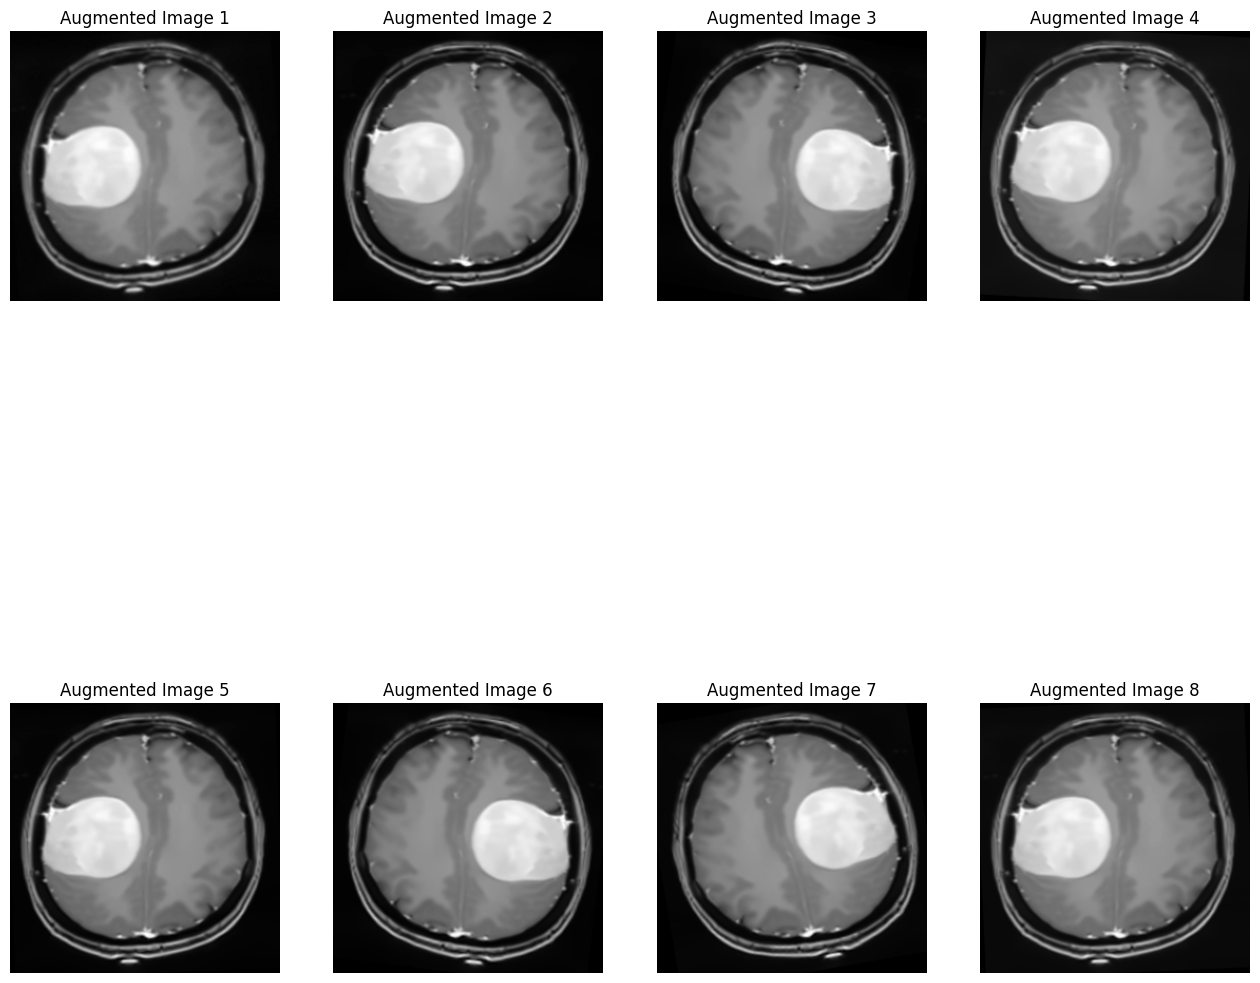

<Figure size 1600x1600 with 0 Axes>

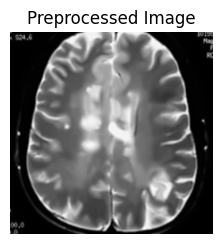

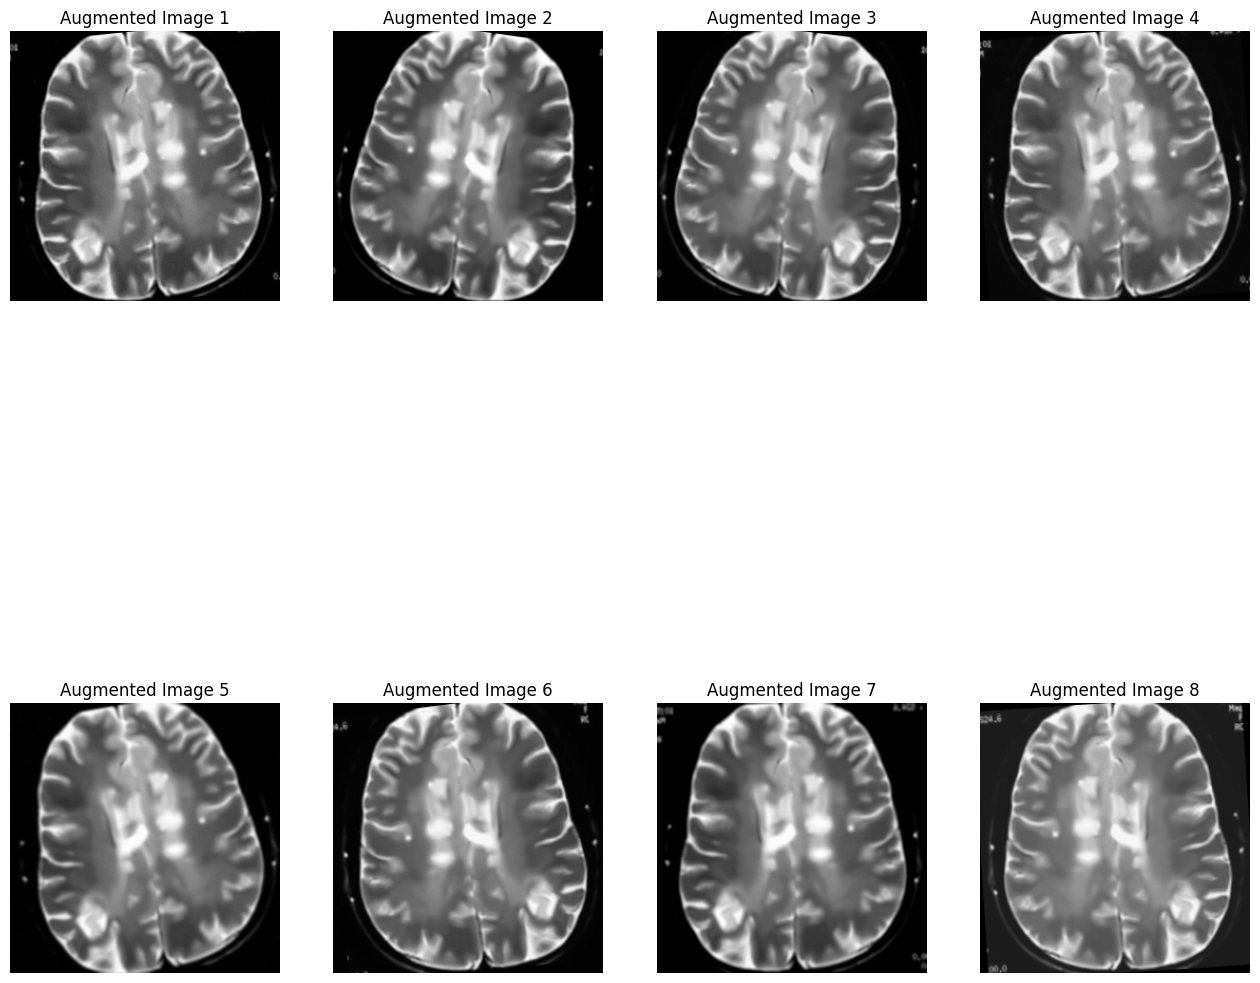

In [ ]:
# Display the first 8 augmented images from 'augmented_yes_tumor'
plt.figure(figsize=(16, 16))

not_augmented_image = yes_tumor[0]  #
plt.subplot(2, 4, 1)
plt.imshow(not_augmented_image, cmap='gray')
plt.title(f"Preprocessed Image")
plt.axis('off')
plt.show()

plt.figure(figsize=(16, 16))

for i in range(8):
    augmented_image = augmented_yes_tumor[i]  # Extract the image data
    plt.subplot(2, 4, i + 1)
    plt.imshow(augmented_image, cmap='gray')
    plt.title(f"Augmented Image {i + 1}")
    plt.axis('off')
plt.show()

plt.figure(figsize=(16, 16))

plt.figure(figsize=(12, 8))
not_augmented_image = no_tumor[0]  #
plt.subplot(2, 4, 1)
plt.imshow(not_augmented_image, cmap='gray')
plt.title(f"Preprocessed Image")
plt.axis('off')
plt.show()

plt.figure(figsize=(16, 16))

# Display the first 8 augmented images from 'augmented_no_tumor'
for i in range(8):
    augmented_image = augmented_no_tumor[i]  # Extract the image data
    plt.subplot(2, 4, i + 1)
    plt.imshow(augmented_image, cmap='gray')
    plt.title(f"Augmented Image {i + 1}")
    plt.axis('off')
plt.show()


Visualize Augmented Data

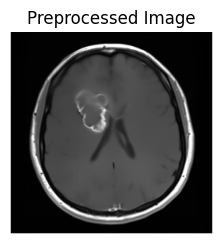

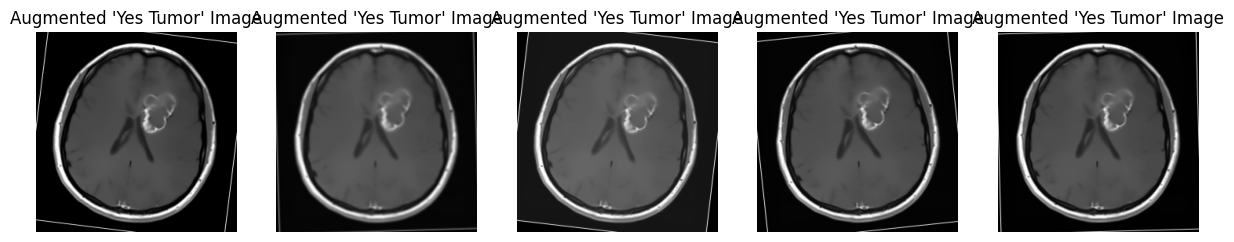

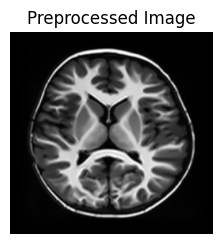

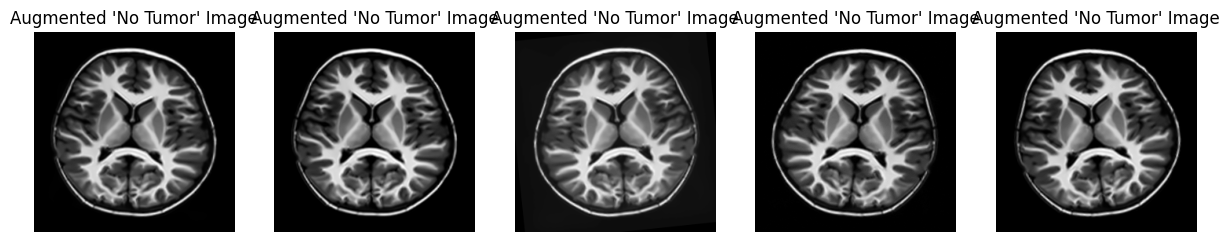

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize images
def visualize_images(images, title):
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"{title} Image")
        plt.axis('off')
    plt.show()

# Visualize original 'yes_tumor' images
plt.figure(figsize=(12, 8))
not_augmented_image = yes_tumor[1]  #
plt.subplot(2, 4, 1)
plt.imshow(not_augmented_image, cmap='gray')
plt.title(f"Preprocessed Image")
plt.axis('off')
plt.show()

# Visualize augmented 'yes_tumor' images
visualize_images(augmented_yes_tumor[8:16], "Augmented 'Yes Tumor'")

plt.figure(figsize=(12, 8))
not_augmented_image = no_tumor[1]  #
plt.subplot(2, 4, 1)
plt.imshow(not_augmented_image, cmap='gray')
plt.title(f"Preprocessed Image")
plt.axis('off')
plt.show()

# Visualize augmented 'no_tumor' images
visualize_images(augmented_no_tumor[8:16], "Augmented 'No Tumor'")


Adjust for single channel


In [ ]:
for i in range(len(augmented_yes_tumor)):
    augmented_yes_tumor[i] = augmented_yes_tumor[i].reshape((256, 256, 1))

for i in range(len(augmented_no_tumor)):
    augmented_no_tumor[i] = augmented_no_tumor[i].reshape((256, 256, 1))

for i in range(len(yes_tumor)):
    yes_tumor[i] = yes_tumor[i].reshape((256, 256, 1))

for i in range(len(no_tumor)):
    no_tumor[i] = no_tumor[i].reshape((256, 256, 1))


print(yes_tumor[0].shape)
print(no_tumor[0].shape)
print(augmented_yes_tumor[0].shape)
print(augmented_no_tumor[0].shape)

(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


#Split the data



In [ ]:
from sklearn.model_selection import train_test_split

# Combine all the data and labels into single lists
all_data = yes_tumor + no_tumor + augmented_yes_tumor + augmented_no_tumor
all_labels = [1] * len(yes_tumor) + [0] * len(no_tumor) + [1] * len(augmented_yes_tumor) + [0] * len(augmented_no_tumor)

# Split the combined data and labels into training (70%), validation (15%), and test (15%) sets
x_train, x_temp, y_train, y_temp = train_test_split(all_data, all_labels, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
# Verify the shapes of the resulting datasets
print("Training data shapes: Total \t-",   len(x_train))
print("Validation data shapes: Total \t-", len(x_val))
print("Test data shapes: Total \t-",       len(x_test))

print("Shape of the data-\t", all_data[0].shape)


Training data shapes: Total 	- 1593
Validation data shapes: Total 	- 342
Test data shapes: Total 	- 342
Shape of the data-	 (256, 256, 1)


Reshaping the Data


In [ ]:
import numpy as np

# Reshape the data
x_train = np.array(x_train).reshape(-1, 256, 256, 1)
x_val = np.array(x_val).reshape(-1, 256, 256, 1)
x_test = np.array(x_test).reshape(-1, 256, 256, 1)

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Verify the shapes
print("Training data shape:\t", x_train.shape)
print("Validation data shape:\t", x_val.shape)
print("Test data shape:\t", x_test.shape)

print("Training data shape:\t", y_train.shape)
print("Validation data shape:\t", y_val.shape)
print("Test data shape:\t", y_test.shape)


Training data shape:	 (1593, 256, 256, 1)
Validation data shape:	 (342, 256, 256, 1)
Test data shape:	 (342, 256, 256, 1)
Training data shape:	 (1593, 1)
Validation data shape:	 (342, 1)
Test data shape:	 (342, 1)


# Feedforward Neural Network (FNN)
Adjusts the shape for single channel

Model Architecture

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()

# Input layer with the correct input shape
model.add(layers.Input(shape=(256, 256, 1)))

# Flatten the input for the fully connected layers
model.add(layers.Flatten())

# Apply batch normalization
model.add(layers.BatchNormalization())

# Add dense hidden layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))

# Display the model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 65536)             0         
                                                                 
 batch_normalization_24 (Ba  (None, 65536)             262144    
 tchNormalization)                                               
                                                                 
 dense_26 (Dense)            (None, 512)               33554944  
                                                                 
 batch_normalization_25 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_19 (Dropout)        (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 256)              

Model Training
Validation accuracy is close to the training accuracy, indicating that your model is not overfitting

In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

# Define the number of epochs and batch size
epochs = 10
batch_size = 32

# Compile the model with a custom learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Training loop
history = model.fit(
    x_train,  # Training data
    y_train,  # Training labels
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),  # Validation data
    verbose=1,  # Set to 1 for training progress
    callbacks=[early_stopping]
)

Epoch 1/10
50/50 [==============================] - 39s 731ms/step - loss: 0.8071 - accuracy: 0.6095 - val_loss: 3.1081 - val_accuracy: 0.6287
Epoch 2/10
50/50 [==============================] - 37s 737ms/step - loss: 0.7075 - accuracy: 0.6792 - val_loss: 0.7056 - val_accuracy: 0.7222
Epoch 3/10
50/50 [==============================] - 41s 823ms/step - loss: 0.6076 - accuracy: 0.7068 - val_loss: 0.5491 - val_accuracy: 0.7251
Epoch 4/10
50/50 [==============================] - 47s 942ms/step - loss: 0.5834 - accuracy: 0.7250 - val_loss: 0.4437 - val_accuracy: 0.7895
Epoch 5/10
50/50 [==============================] - 44s 867ms/step - loss: 0.5669 - accuracy: 0.7338 - val_loss: 0.4229 - val_accuracy: 0.8099
Epoch 6/10
50/50 [==============================] - 51s 1s/step - loss: 0.4723 - accuracy: 0.7778 - val_loss: 0.3775 - val_accuracy: 0.8158
Epoch 7/10
50/50 [==============================] - 42s 842ms/step - loss: 0.4480 - accuracy: 0.7922 - val_loss: 0.3232 - val_accuracy: 0.8333
Ep

#Dense Neural Network (DNN)


Model Architecture

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the custom DNN model
model = keras.Sequential()

# Input layer with the correct input shape
model.add(layers.Input(shape=(256, 256, 1)))

# Flatten the input for the fully connected layers
model.add(layers.Flatten())

# Apply batch normalization
model.add(layers.BatchNormalization())

# Add dense hidden layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))

# Display the model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 65536)             0         
                                                                 
 batch_normalization_5 (Bat  (None, 65536)             262144    
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 512)               33554944  
                                                                 
 batch_normalization_6 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)              

Model Training Based on Intensity

In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

# Define the number of epochs and batch size
epochs = 15
batch_size = 32

# Compile the model with a custom learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Training loop
history = model.fit(
    x_train,  # Training data
    y_train,  # Training labels
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),  # Validation data
    verbose=1,  # Set to 1 for training progress
    callbacks=[early_stopping]
)

Epoch 1/15
50/50 [==============================] - 41s 711ms/step - loss: 0.8757 - accuracy: 0.5926 - val_loss: 1.3926 - val_accuracy: 0.6199
Epoch 2/15
50/50 [==============================] - 35s 710ms/step - loss: 0.7710 - accuracy: 0.6403 - val_loss: 0.6384 - val_accuracy: 0.7105
Epoch 3/15
50/50 [==============================] - 39s 765ms/step - loss: 0.6715 - accuracy: 0.6685 - val_loss: 0.4916 - val_accuracy: 0.7573
Epoch 4/15
50/50 [==============================] - 35s 709ms/step - loss: 0.6523 - accuracy: 0.6937 - val_loss: 0.4582 - val_accuracy: 0.8070
Epoch 5/15
50/50 [==============================] - 35s 702ms/step - loss: 0.5606 - accuracy: 0.7244 - val_loss: 0.4545 - val_accuracy: 0.7749
Epoch 6/15
50/50 [==============================] - 34s 681ms/step - loss: 0.5406 - accuracy: 0.7552 - val_loss: 0.3928 - val_accuracy: 0.8216
Epoch 7/15
50/50 [==============================] - 38s 753ms/step - loss: 0.4860 - accuracy: 0.7728 - val_loss: 0.3582 - val_accuracy: 0.8363


# Pre-trained Model DenseNet 121


fine-tune the model on your specific dataset
 load the pre-trained weights and then add your own custom layers (classification head) on top of the pre-trained model
 train this combined model (pre-trained layers + custom layers) on your dataset

In [ ]:
print("Training data shape:\t", x_train.shape)
print("Validation data shape:\t", x_val.shape)
print("Test data shape:\t", x_test.shape)

print("Training data label:\t", y_train.shape)
print("Validation data label:\t", y_val.shape)
print("Test data label:\t", y_test.shape)

Training data shape:	 (531, 256, 256, 3)
Validation data shape:	 (114, 256, 256, 3)
Test data shape:	 (114, 256, 256, 3)
Training data label:	 (1593, 1)
Validation data label:	 (342, 1)
Test data label:	 (342, 1)


In [ ]:
print(len(x_train))
print(len(y_train))

1593
1593


In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Load your single-channel (grayscale) images
x_train_gray = x_train  # Load your training data
x_val_gray = x_val    # Load your validation data
x_test_gray = x_test   # Load your test data

# Convert grayscale images to RGB format by repeating the channel
x_train_rgb = np.repeat(x_train_gray, 3, axis=-1)
x_val_rgb = np.repeat(x_val_gray, 3, axis=-1)
x_test_rgb = np.repeat(x_test_gray, 3, axis=-1)

# Define the number of epochs and batch size
epochs = 10
batch_size = 32

# Load pre-trained DenseNet model (excluding top classification layer)
base_model = keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add custom classification head
model = keras.Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile the model with custom learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Training loop
history = model.fit(
    x_train_rgb,  # Training data (ensure shape (N, 256, 256, 3))
    y_train,  # Training labels
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val_rgb, y_val),  # Validation data
    verbose=1,  # Set to 1 for training progress
    callbacks=[early_stopping]
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test_rgb, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
50/50 [==============================] - 108s 711ms/step - loss: 1.3778 - accuracy: 0.7640 - val_loss: 11017.8125 - val_accuracy: 0.6140
Epoch 2/10
50/50 [==============================] - 22s 441ms/step - loss: 0.4516 - accuracy: 0.8569 - val_loss: 13.4472 - val_accuracy: 0.7076
Epoch 3/10
50/50 [==============================] - 22s 438ms/step - loss: 0.4176 - accuracy: 0.8682 - val_loss: 10545.3398 - val_accuracy: 0.6316
Epoch 4/10
50/50 [==============================] - 22s 446ms/step - loss: 0.1657 - accuracy: 0.9190 - val_loss: 0.6869 - val_accuracy: 0.9006
Epoch 5/10
50/50 [==============================] - 22s 446ms/step - loss: 0.5243 - accuracy: 0.8908 - val_loss: 10486.7568 - val_accuracy: 0.6082
Epoch 6/10
50/50 [==============================] - 22s 446ms/step - loss: 0.6833 - accuracy: 0.8343 - val_loss: 11943.4814 - val_accuracy: 0.6053
Epoch 7/10
50/50 [==============================] - 23s 452ms/step - loss: 1.0230 - accuracy: 0.8048 - val_loss: 39.0537 - v

#Model Evaluation, Post-processing & Visualization

Test the Model on Unseen Data


use the test data, which the model has not seen during training, to evaluate its performance.
The result show the percent of correctly classified test data.

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


11/11 [==============================] - 1s 128ms/step - loss: 0.1674 - accuracy: 0.9152
Test Loss: 0.16739368438720703
Test Accuracy: 0.9152047038078308


**Confusion** Matrix
Create a confusion matrix to analyze the true positives, true negatives, false positives, and false negatives.

In [ ]:
from sklearn.metrics import confusion_matrix

# Assuming you have model predictions 'y_pred' and true labels 'y_true'
y_pred = model.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Apply a threshold for binary classification

# Compute the confusion matrix
confusion = confusion_matrix(y_test, y_pred_binary)

# Extract values from the confusion matrix
true_negatives, false_positives, false_negatives, true_positives = confusion.ravel()

# Calculate sensitivity (true positive rate) and specificity (true negative rate)
sensitivity = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print("True Positives:", true_positives, "True Negative", true_negatives)
print("False Positives:", false_positives, "False Negative", false_negatives)

# Print the confusion matrix and metrics
print("Confusion Matrix:")
print(confusion)
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

11/11 [==============================] - 1s 63ms/step
True Positives: 205 True Negative 108
False Positives: 25 False Negative 4
Confusion Matrix:
[[108  25]
 [  4 205]]
Sensitivity (True Positive Rate): 0.9808612440191388
Specificity (True Negative Rate): 0.8120300751879699


Precision, Recall, and F1-Score

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Assuming y_pred is an array of continuous probabilities
threshold = 0.5  # Adjust the threshold as needed
y_pred_binary = (y_pred > threshold).astype(int)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate individual metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print individual metrics
print("\nAccuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       133
           1       0.89      0.98      0.93       209

    accuracy                           0.92       342
   macro avg       0.93      0.90      0.91       342
weighted avg       0.92      0.92      0.91       342


Accuracy: 0.92
Precision: 0.89
Recall: 0.98
F1 Score: 0.93


ROC Curve and AUC

plot the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC) to assess the model's ability to discriminate between classes.



11/11 [==============================] - 1s 62ms/step


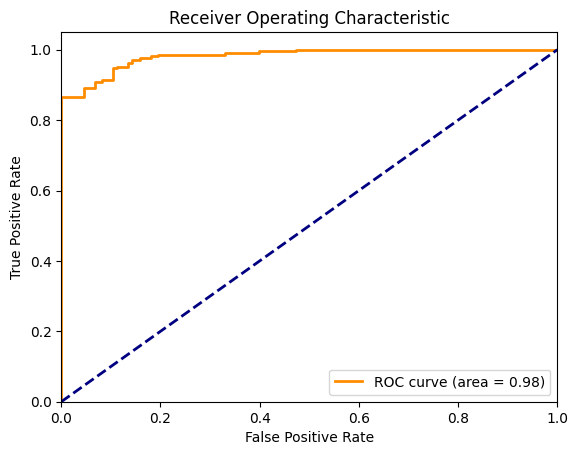

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have a trained model and test data
predictions = model.predict(x_test)  # Assuming x_test contains your test data

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
